In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
df=pd.read_csv(r"HR_comma_sep.csv")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


In [5]:
df = df.rename(columns={'left': 'churn'})

In [6]:
df = df.rename(columns={'promotion_last_5years': 'treatment'})

In [7]:
df.salary = df.salary.map({'low': 0, 'medium': 1, 'high':2})

In [8]:
print('Categorical columns: ')
for col in df.columns:
    if df[col].dtype == 'object':
        values = df[col].value_counts()
        values = dict(values)

        print(str(col))
        label = LabelEncoder()
        label = label.fit(df[col])
        df[col] = label.transform(df[col].astype(str))

        new_values = df[col].value_counts()
        new_values = dict(new_values)

        value_dict = {}
        i=0
        for key in values:
            value_dict[key] = list(new_values)[i]
            i+= 1
        print(value_dict)

Categorical columns: 
Department
{'sales': 7, 'technical': 9, 'support': 8, 'IT': 0, 'product_mng': 6, 'marketing': 5, 'RandD': 1, 'accounting': 2, 'hr': 3, 'management': 4}


In [9]:
column_to_move1 = df.pop('treatment')
df['treatment'] = column_to_move1

column_to_move2 = df.pop('churn')
df['churn'] = column_to_move2

In [10]:
df = df.astype(int)

In [11]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Department,salary,treatment,churn
0,0,0,2,157,3,0,7,0,0,1
1,0,0,5,262,6,0,7,1,0,1
2,0,0,7,272,4,0,7,1,0,1
3,0,0,5,223,5,0,7,0,0,1
4,0,0,2,159,3,0,7,0,0,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   satisfaction_level    14999 non-null  int64
 1   last_evaluation       14999 non-null  int64
 2   number_project        14999 non-null  int64
 3   average_montly_hours  14999 non-null  int64
 4   time_spend_company    14999 non-null  int64
 5   Work_accident         14999 non-null  int64
 6   Department            14999 non-null  int64
 7   salary                14999 non-null  int64
 8   treatment             14999 non-null  int64
 9   churn                 14999 non-null  int64
dtypes: int64(10)
memory usage: 1.1 MB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.007400,0.085710,0.0,0.0,0.0,0.0,1.0
last_evaluation,14999.0,0.018868,0.136063,0.0,0.0,0.0,0.0,1.0
number_project,14999.0,3.803054,1.232592,2.0,3.0,4.0,5.0,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.0,156.0,200.0,245.0,310.0
time_spend_company,14999.0,3.498233,1.460136,2.0,3.0,3.0,4.0,10.0
Work_accident,14999.0,0.144610,0.351719,0.0,0.0,0.0,0.0,1.0
Department,14999.0,5.870525,2.868786,0.0,4.0,7.0,8.0,9.0
salary,14999.0,0.594706,0.637183,0.0,0.0,1.0,1.0,2.0
treatment,14999.0,0.021268,0.144281,0.0,0.0,0.0,0.0,1.0
churn,14999.0,0.238083,0.425924,0.0,0.0,0.0,0.0,1.0


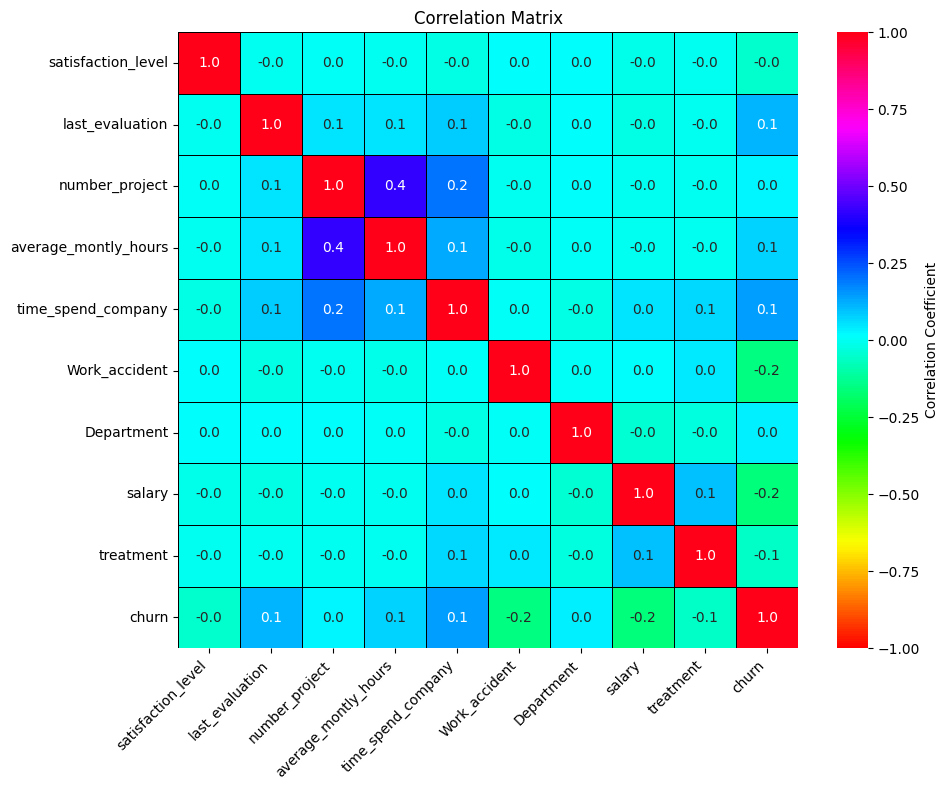

In [14]:
df_corr = df.corr()

plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(df_corr, annot=True, cmap='hsv',
            fmt=".1f", linewidths=0.5, linecolor='black',
            annot_kws={"size": 10}, vmin=-1, vmax=1)

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('Correlation Coefficient')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()

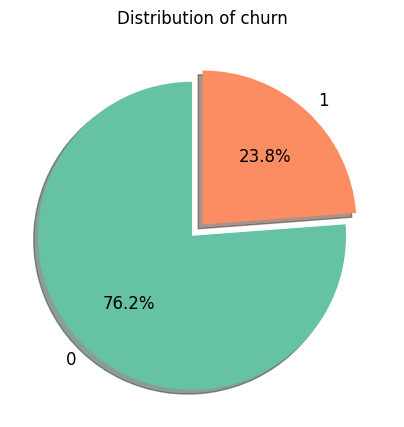

In [15]:
event_counts = df['churn'].value_counts()

plt.figure(figsize=(5, 5))
colors = ['#66c2a5', '#fc8d62']
explode = (0.1, 0)

plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, explode=explode, shadow=True,
        textprops={'fontsize': 12})
plt.title("Distribution of churn")
plt.show()

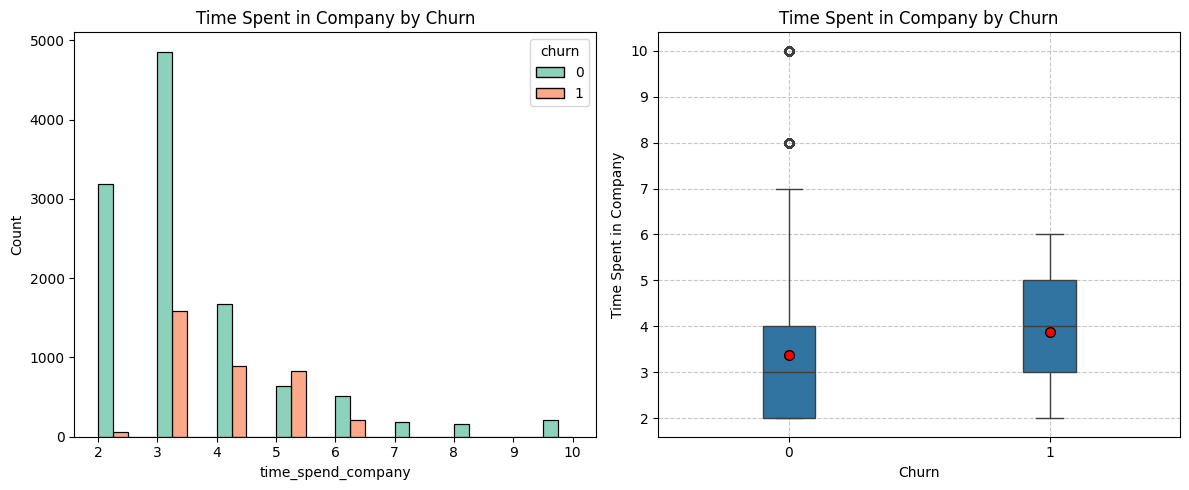

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df, x="time_spend_company", hue="churn",
             multiple="dodge", kde=False, binwidth=0.5, palette="Set2",
             edgecolor="black", ax=axes[0])
axes[0].set_title("Time Spent in Company by Churn")

sns.boxplot(data=df, x="churn", y="time_spend_company", showmeans=True, width=0.2,
            meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black", "markersize": 7}, ax=axes[1])
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xlabel("Churn")
axes[1].set_ylabel("Time Spent in Company")
axes[1].set_title("Time Spent in Company by Churn")

plt.tight_layout()
plt.show()

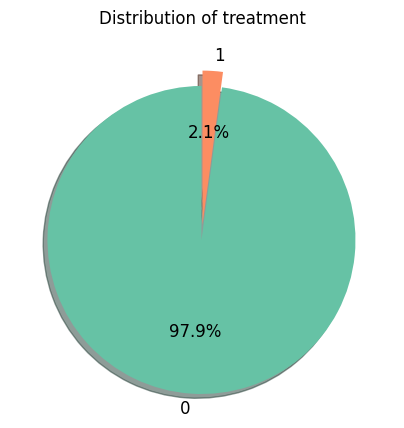

In [17]:
treatment_counts = df['treatment'].value_counts()

plt.figure(figsize=(5, 5))
colors = ['#66c2a5', '#fc8d62']
explode = (0.1, 0)
plt.pie(treatment_counts, labels=treatment_counts.index, autopct='%1.1f%%', 
    startangle=90, colors=colors, explode=explode, shadow=True,
    textprops={'fontsize': 12})
plt.title("Distribution of treatment")
plt.show()


In [18]:
def declare_target_class(df:pd.DataFrame):

    #CN:
    df['target_class'] = 0 # Same as df.loc[(df.treatment == 0) & (df.churn == 1),'target_class'] = 0
    #CR:
    df.loc[(df.treatment == 0) & (df.churn == 0),'target_class'] = 1
    #TN:
    df.loc[(df.treatment == 1) & (df.churn == 1),'target_class'] = 2
    #TR:
    df.loc[(df.treatment == 1) & (df.churn == 0),'target_class'] = 3

    return df

df = declare_target_class(df)

In [19]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Department,salary,treatment,churn,target_class
0,0,0,2,157,3,0,7,0,0,1,0
1,0,0,5,262,6,0,7,1,0,1,0
2,0,0,7,272,4,0,7,1,0,1,0
3,0,0,5,223,5,0,7,0,0,1,0
4,0,0,2,159,3,0,7,0,0,1,0


In [20]:
X = df.drop(['churn','target_class'],axis=1)
y = df.churn
z = df.target_class
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X,y,z,test_size=0.3,random_state=42,stratify=df['treatment'])

X_train.shape, y_train.shape, z_train.shape, X_test.shape

((10499, 9), (10499,), (10499,), (4500, 9))

In [21]:
# n_estimators_options = range(250, 350, 10)

# learning_rate_options = np.arange(0.3, 0.50, 0.01)


# best_score = 0
# best_params = {}

# for n_estimators in n_estimators_options:
#     for learning_rate in learning_rate_options:
#         model = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
#         model.fit(X_train.drop('treatment', axis=1), y_train)

#         y_pred = model.predict(X_test.drop('treatment', axis=1))

#         accuracy = accuracy_score(y_test, y_pred)

#         if accuracy > best_score:
#             best_score = accuracy
#             best_params = {
#                 'n_estimators': n_estimators,
#                 'learning_rate': learning_rate
#             }

#         print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, Accuracy: {accuracy:.4f}")

# print("Best Parameters:", best_params)
# print("Best Accuracy Score:", best_score)

## Model 1

In [22]:
prediction_results = pd.DataFrame(X_test.drop('treatment',axis=1)).copy()

model_1 = xgb.XGBClassifier(n_estimators=260, learning_rate=0.46000000000000013)

model_1.fit(X_train.drop('treatment', axis=1), y_train)

prediction = model_1.predict(X_test.drop('treatment',axis=1))

probability = model_1.predict_proba(X_test.drop('treatment', axis=1))

prediction_results['churn'] = y_test

prediction_results['prediction_churn'] = prediction

prediction_results['proba_churn'] = probability[:,1]

In [23]:
classification_rep = classification_report(y_test, prediction)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3436
           1       0.92      0.95      0.93      1064

    accuracy                           0.97      4500
   macro avg       0.95      0.96      0.96      4500
weighted avg       0.97      0.97      0.97      4500



In [24]:
prediction_results.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Department,salary,churn,prediction_churn,proba_churn
3815,0,0,5,200,3,0,7,1,0,0,5.884666e-05
14222,0,0,6,305,4,0,7,0,1,1,9.998086e-01
11744,0,0,4,145,3,0,7,0,0,0,1.438972e-03
12932,0,0,4,207,2,1,9,1,0,0,2.514371e-05
13841,0,0,4,162,10,0,4,2,0,0,1.913371e-07


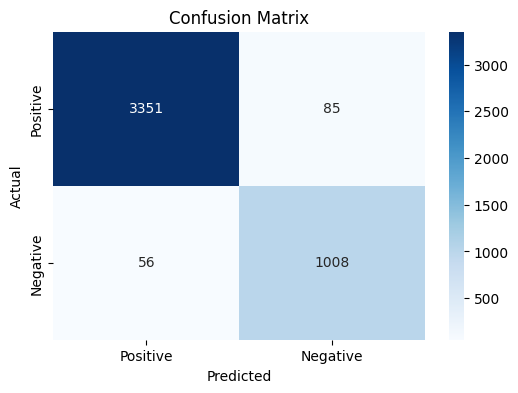

In [25]:
cm = confusion_matrix(y_test, prediction)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive','Negative'], yticklabels=['Positive','Negative'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

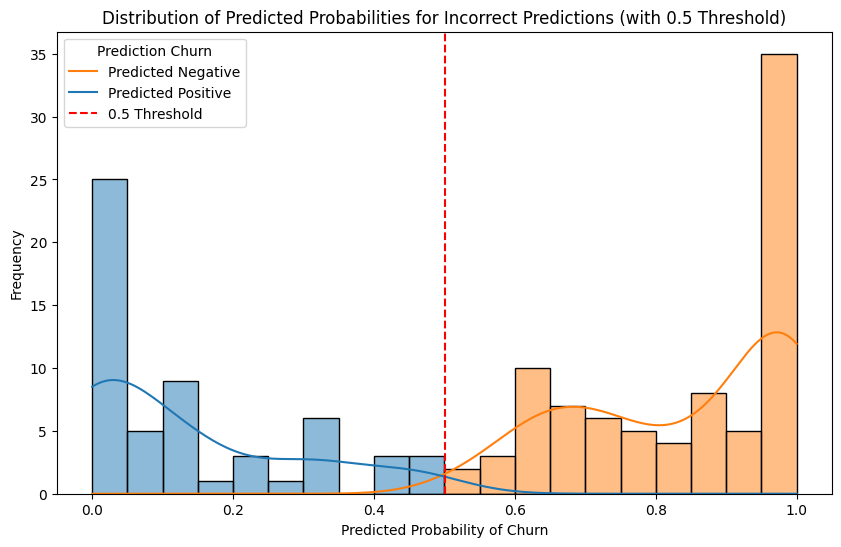

In [26]:
incorrect_predictions = prediction_results[prediction_results['prediction_churn'] != prediction_results['churn']]

incorrect_predictions_sorted = incorrect_predictions.sort_values(by='proba_churn')

plt.figure(figsize=(10, 6))

sns.histplot(data=incorrect_predictions_sorted, x="proba_churn", hue="prediction_churn", kde=True, bins=20)

plt.axvline(0.5, color='red', linestyle='--', label='0.5 Probability Threshold')

plt.title("Distribution of Predicted Probabilities for Incorrect Predictions (with 0.5 Threshold)")
plt.xlabel("Predicted Probability of Churn")
plt.ylabel("Frequency")
plt.legend(title="Prediction Churn", labels=["Predicted Negative", "Predicted Positive", "0.5 Threshold"])
plt.show()

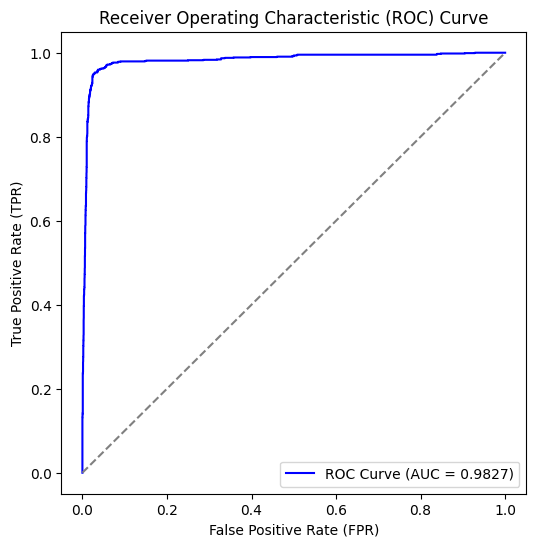

In [27]:
y_pred_proba = model_1.predict_proba(X_test.drop('treatment', axis=1))[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [28]:
leaf_indices = model_1.apply(X_test.drop('treatment', axis=1))[-1]
print("Leaf indices:\n", leaf_indices)

Leaf indices:
 [50. 51. 53. 51. 39. 54. 37. 45. 42. 15. 36. 39. 27. 23. 23. 33. 19. 29.
 28. 26. 40. 29. 48. 16. 50. 54. 88. 43. 20. 29. 40. 44. 60. 47. 28. 47.
 37. 39. 51. 66. 16. 54. 53. 45.  8. 45. 24. 57. 16. 45. 60. 55. 45. 44.
 52. 64. 31. 22. 16. 56. 40.  8. 78. 57. 79. 41. 27. 88. 64. 31. 58. 43.
 63. 38. 38. 76. 56. 21. 44. 28. 26. 56. 55. 58. 64. 48. 22. 17. 22. 30.
 29.  8. 50. 37. 47. 33. 46. 37.  7. 31. 54. 50. 29. 23. 41. 29. 48. 65.
 40. 54. 67. 39. 46. 32. 18. 47. 43. 24. 37. 82. 29. 41. 20. 53. 51. 69.
 30. 36. 63. 41. 20. 55. 17. 40. 45. 19. 25. 49. 18. 54. 32. 36. 64. 11.
 16. 66. 60. 47. 67. 31. 61. 35.  8. 17. 40. 45. 57. 14. 50. 25. 38. 49.
 30. 37. 36. 34. 34. 32. 17. 39. 27. 42. 35. 38. 41. 31. 47. 17. 24. 38.
 48. 44. 54. 28. 22. 29. 40. 28. 39.  8. 13. 26. 41. 49. 42. 37. 33. 50.
 47. 26. 48. 52. 41. 27. 40. 30. 26. 42. 39. 33.  8. 64. 17. 37. 27. 34.
 62. 50. 37. 19. 42. 10. 27. 38. 26. 31. 42. 20. 52. 25. 66. 48. 42. 26.
 35. 49. 42. 35. 46. 48. 56.  7. 35.

In [29]:
booster = model_1.get_booster()
trees = booster.get_dump()
print("Last tree structure:\n", trees[-1])  # View structure of the first tree


Last tree structure:
 0:[average_montly_hours<132] yes=1,no=2,missing=2
	1:[average_montly_hours<127] yes=3,no=4,missing=4
		3:leaf=-0.0247771051
		4:[salary<1] yes=7,no=8,missing=8
			7:[average_montly_hours<130] yes=13,no=14,missing=14
				13:leaf=0.0410208888
				14:leaf=-0.0397167541
			8:leaf=0.113976054
	2:[salary<2] yes=5,no=6,missing=6
		5:[Department<9] yes=9,no=10,missing=10
			9:[average_montly_hours<133] yes=15,no=16,missing=16
				15:leaf=-0.0532847568
				16:[number_project<6] yes=21,no=22,missing=22
					21:[last_evaluation<1] yes=27,no=28,missing=28
						27:leaf=-0.00272966083
						28:leaf=0.0728501305
					22:[average_montly_hours<274] yes=29,no=30,missing=30
						29:leaf=0.0461898968
						30:leaf=-0.0379794054
			10:[average_montly_hours<141] yes=17,no=18,missing=18
				17:leaf=0.0536469594
				18:[average_montly_hours<143] yes=23,no=24,missing=24
					23:leaf=-0.112328358
					24:[number_project<5] yes=31,no=32,missing=32
						31:leaf=0.0120903663
						32:leaf=

In [30]:
# Access the booster and get all trees as a list of strings
booster = model_1.get_booster()
trees = booster.get_dump()

# Print the structure of each tree and count leaves
for i, tree in enumerate(trees):
    num_leaves = tree.count("leaf")
    print(f"Tree {i + 1} has {num_leaves} leaves")


Tree 1 has 35 leaves
Tree 2 has 36 leaves
Tree 3 has 39 leaves
Tree 4 has 40 leaves
Tree 5 has 25 leaves
Tree 6 has 44 leaves
Tree 7 has 25 leaves
Tree 8 has 31 leaves
Tree 9 has 28 leaves
Tree 10 has 11 leaves
Tree 11 has 31 leaves
Tree 12 has 26 leaves
Tree 13 has 20 leaves
Tree 14 has 13 leaves
Tree 15 has 15 leaves
Tree 16 has 20 leaves
Tree 17 has 14 leaves
Tree 18 has 22 leaves
Tree 19 has 15 leaves
Tree 20 has 41 leaves
Tree 21 has 27 leaves
Tree 22 has 20 leaves
Tree 23 has 25 leaves
Tree 24 has 11 leaves
Tree 25 has 28 leaves
Tree 26 has 28 leaves
Tree 27 has 45 leaves
Tree 28 has 28 leaves
Tree 29 has 17 leaves
Tree 30 has 19 leaves
Tree 31 has 28 leaves
Tree 32 has 26 leaves
Tree 33 has 31 leaves
Tree 34 has 25 leaves
Tree 35 has 27 leaves
Tree 36 has 41 leaves
Tree 37 has 28 leaves
Tree 38 has 24 leaves
Tree 39 has 34 leaves
Tree 40 has 43 leaves
Tree 41 has 39 leaves
Tree 42 has 28 leaves
Tree 43 has 33 leaves
Tree 44 has 25 leaves
Tree 45 has 27 leaves
Tree 46 has 29 leav

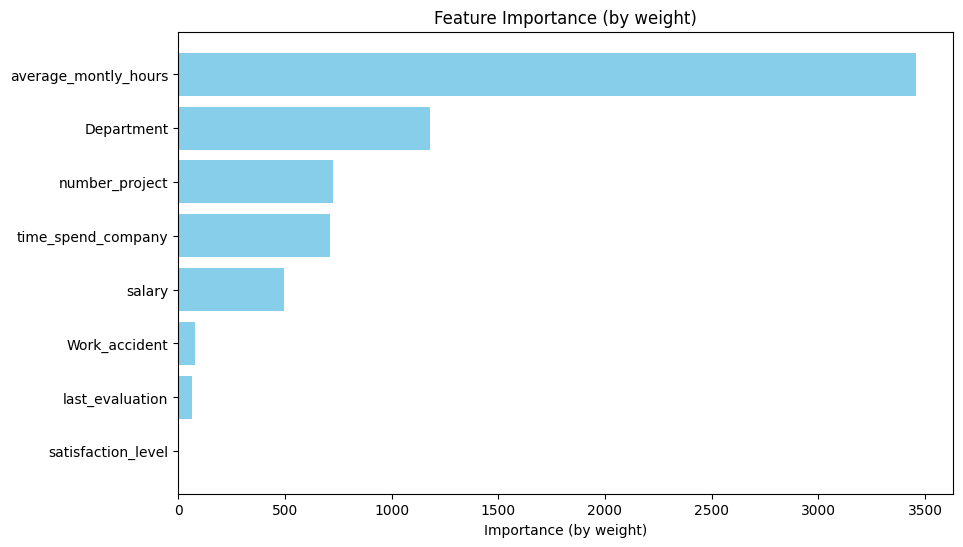

In [31]:
feature_importance = booster.get_score(importance_type='weight')

features = list(feature_importance.keys())
importance_scores = list(feature_importance.values())

sorted_indices = np.argsort(importance_scores)
sorted_features = [features[i] for i in sorted_indices]
sorted_importance_scores = [importance_scores[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance_scores, color="skyblue")
plt.xlabel("Importance (by weight)")
plt.title("Feature Importance (by weight)")
plt.show()

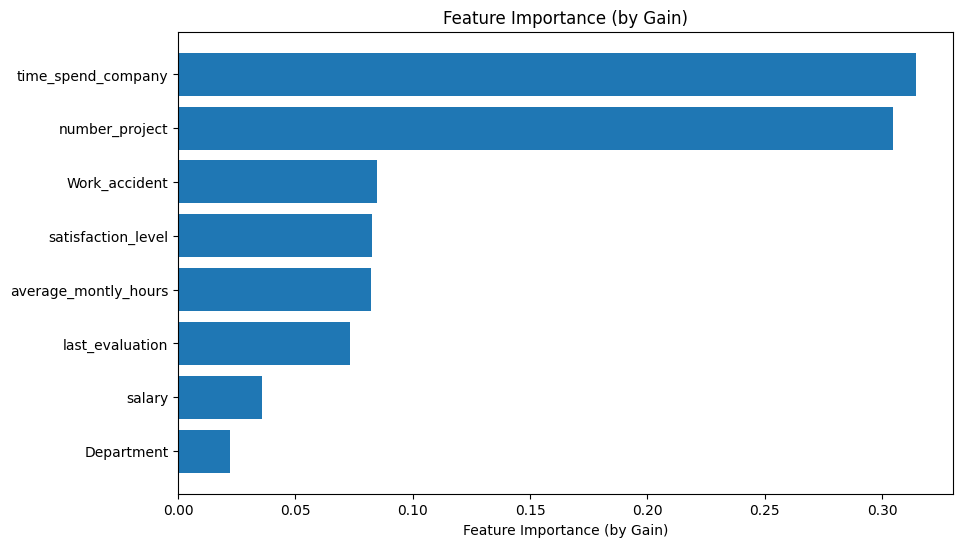

In [32]:
importance = model_1.feature_importances_
features = X.columns.drop('treatment')

sorted_idx = importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importance[sorted_idx])
plt.xlabel("Feature Importance (by Gain)")
plt.title("Feature Importance (by Gain)")
plt.show()

Model 2

In [33]:
prediction_results = pd.DataFrame(X_test.drop('treatment',axis=1)).copy()

model_2 = xgb.XGBClassifier()

model_2.fit(X_train.drop('treatment', axis=1), z_train)

prediction = model_2.predict(X_test.drop('treatment', axis=1))

probability = model_2.predict_proba(X_test.drop('treatment', axis=1))

prediction_results['target_class'] = z_test

prediction_results['prediction_target_class'] = prediction

prediction_results['proba_CN'] = probability[:,0]

prediction_results['proba_CR'] = probability[:,1]

prediction_results['proba_TN'] = probability[:,2]

prediction_results['proba_TR'] = probability[:,3]

In [34]:
prediction_results.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Department,salary,target_class,prediction_target_class,proba_CN,proba_CR,proba_TN,proba_TR
3815,0,0,5,200,3,0,7,1,1,1,0.003251,0.977542,0.000004,0.019202
14222,0,0,6,305,4,0,7,0,0,0,0.999083,0.000198,0.000687,0.000033
11744,0,0,4,145,3,0,7,0,1,1,0.012925,0.968065,0.000283,0.018727
12932,0,0,4,207,2,1,9,1,1,1,0.001427,0.988455,0.000007,0.010110
13841,0,0,4,162,10,0,4,2,1,1,0.000070,0.868914,0.000065,0.130951


In [35]:
classification_rep = classification_report(z_test, prediction)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1057
           1       0.96      0.97      0.96      3347
           2       0.50      0.29      0.36         7
           3       0.73      0.25      0.37        89

    accuracy                           0.94      4500
   macro avg       0.78      0.61      0.65      4500
weighted avg       0.94      0.94      0.94      4500



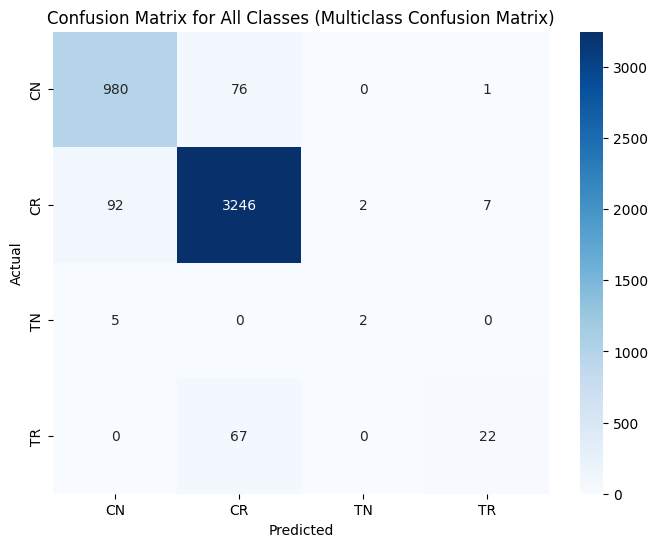

In [36]:
cm = confusion_matrix(z_test, prediction)


class_labels = ['CN', 'CR', 'TN', 'TR']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for All Classes (Multiclass Confusion Matrix)')
plt.show()

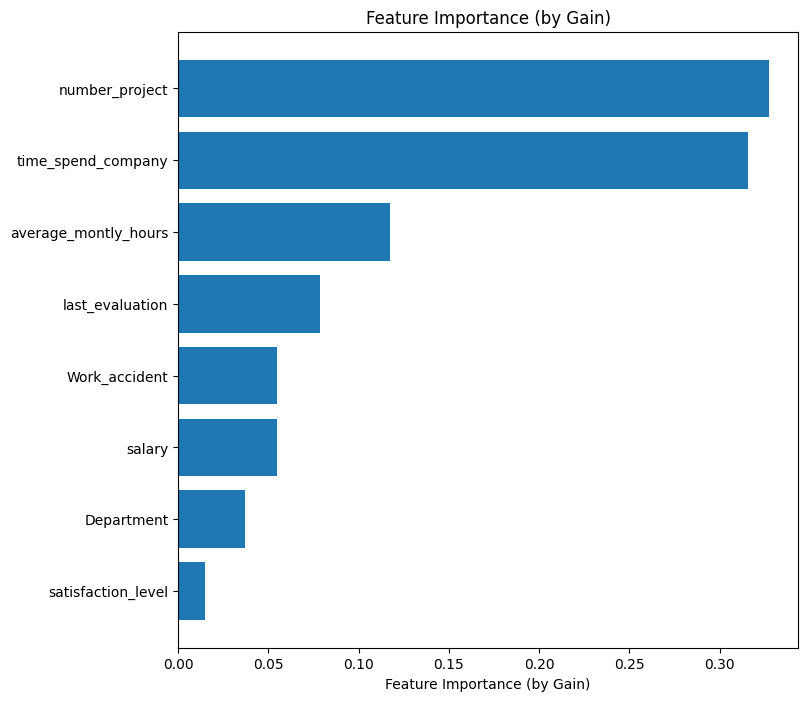

In [37]:
importance = model_2.feature_importances_
features = X.columns.drop('treatment')

sorted_idx = importance.argsort()

plt.figure(figsize=(8, 8))
plt.barh(features[sorted_idx], importance[sorted_idx])
plt.xlabel("Feature Importance (by Gain)")
plt.title("Feature Importance (by Gain)")
plt.show()

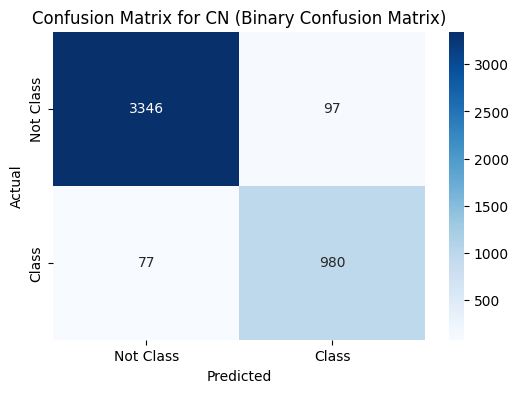

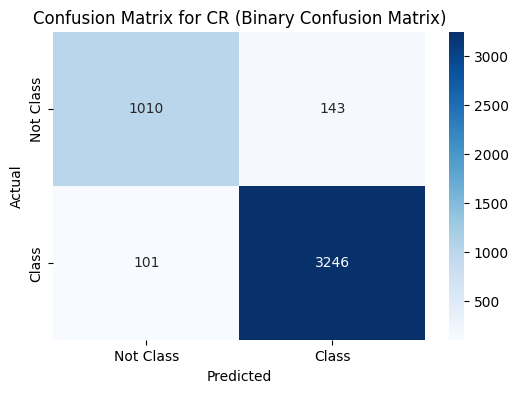

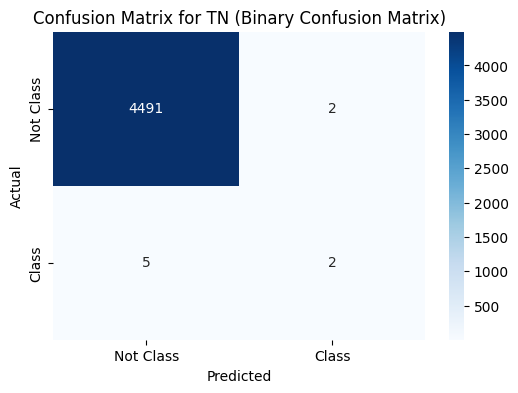

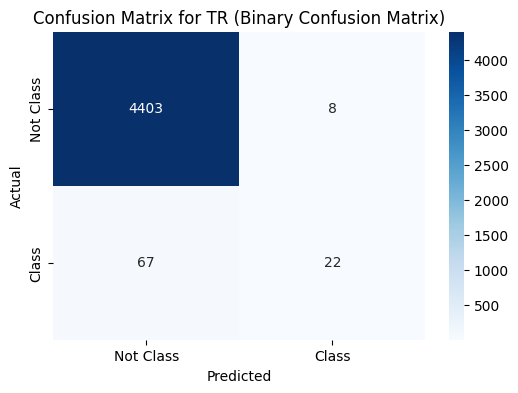

In [38]:
class_labels = ['CN', 'CR', 'TN', 'TR']

confusion_matrices = {}

for i, label in enumerate(class_labels):
    cm = confusion_matrix(z_test == i, prediction == i)
    confusion_matrices[label] = cm


def plot_confusion_matrix(cm, class_name):
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Class','Class'], yticklabels=['Not Class','Class'])
    plt.title(f'Confusion Matrix for {class_name} (Binary Confusion Matrix)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

for class_name, cm in confusion_matrices.items():
    plot_confusion_matrix(cm, class_name)

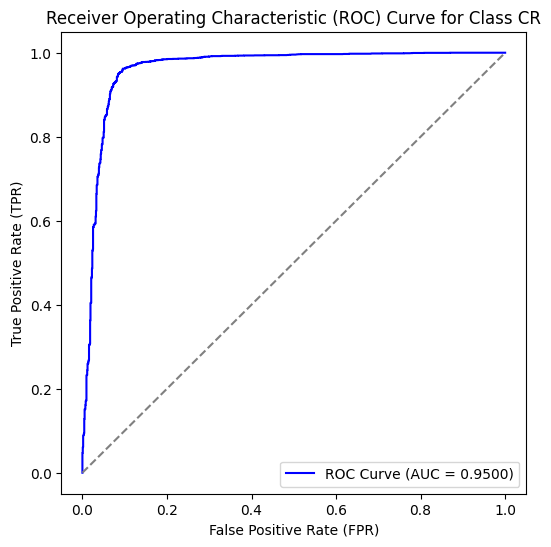

In [39]:
roc_auc = roc_auc_score(z_test, probability, multi_class='ovr')

fpr, tpr, thresholds = roc_curve(z_test, probability[:, 1], pos_label=1)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Class CR')
plt.legend()
plt.show()

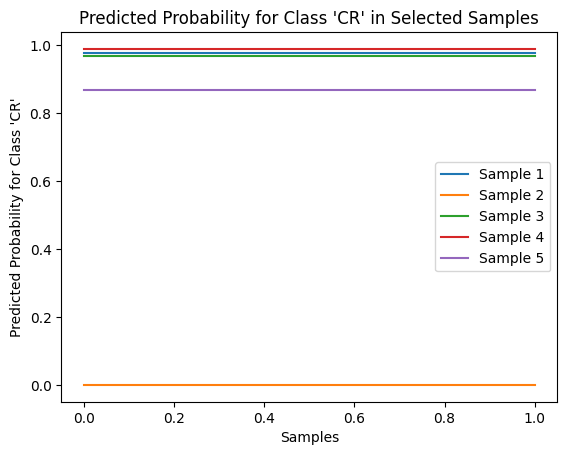

Sample 1: Estimated probability for class CR = 0.9775
Sample 2: Estimated probability for class CR = 0.0002
Sample 3: Estimated probability for class CR = 0.9681
Sample 4: Estimated probability for class CR = 0.9885
Sample 5: Estimated probability for class CR = 0.8689


In [40]:

class_CR_index = 1

probabilities_new = model_2.predict_proba(X_test.drop('treatment', axis=1)[:5])

for i in range(5):
    surv_prob = probabilities_new[i, class_CR_index]
    plt.step([0, 1], [surv_prob, surv_prob], where="mid", label=f"Sample {i+1}")

plt.title("Predicted Probability for Class 'CR' in Selected Samples")
plt.xlabel("Samples")
plt.ylabel("Predicted Probability for Class 'CR'")
plt.legend()
plt.show()

for i in range(5):
    print(f"Sample {i+1}: Estimated probability for class CR = {probabilities_new[i, class_CR_index]:.4f}")